In [36]:
!pip install --upgrade imbalanced-learn==0.10.1
!pip install tensorflow keras

import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16

In [37]:

IMG_SIZE = (224, 224)  
BATCH_SIZE = 16
EPOCHS = 100
data_dir = "/kaggle/input/ppmi-3/MRI-CONV--v1"
classes = ["NONPD", "PD"]

X, y = [], []
for idx, cls in enumerate(classes):
    class_path = os.path.join(data_dir, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  
        X.append(img)
        y.append(idx)

X = np.array(X) / 255.0
y = np.array(y)

In [38]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [39]:
nsamples, nx, ny, nch = X_train.shape
X_train_flat = X_train.reshape((nsamples, nx*ny*nch))
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_flat, y_train)
X_train_res = X_train_res.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 3)

y_train_res_cat = to_categorical(y_train_res, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

In [40]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  


In [41]:
model = models.Sequential([
    base_model,

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 7, 7, 32)       │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,565,666 (63.19 MB)

 Trainable params: 1,848,994 (7.05 MB)

 Non-trainable params: 14,716,672 (56.14 MB)

In [42]:
history = model.fit(
    X_train_res, y_train_res_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 218ms/step - accuracy: 0.6334 - loss: 1.0988 - val_accuracy: 0.3645 - val_loss: 0.7056
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.7707 - loss: 0.5374 - val_accuracy: 0.2710 - val_loss: 0.8298
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.8621 - loss: 0.3298 - val_accuracy: 0.3084 - val_loss: 0.9814
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.8972 - loss: 0.2756 - val_accuracy: 0.6869 - val_loss: 0.6040
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.9302 - loss: 0.1865 - val_accuracy: 0.8037 - val_loss: 0.4345
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.9533 - loss: 0.1284 - val_accuracy: 0.7991 - val_loss: 0.4960
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.9648 - loss: 0.0996 - val_accuracy: 0.6636 - val_loss: 0.9462
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9734 - loss: 0.0692 - 

In [43]:
# ---------------- PREDICTIONS ----------------
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step



Classification Report:

              precision    recall  f1-score   support

       NONPD       0.71      0.56      0.63        54
          PD       0.86      0.93      0.89       160

    accuracy                           0.83       214
   macro avg       0.79      0.74      0.76       214
weighted avg       0.82      0.83      0.82       214



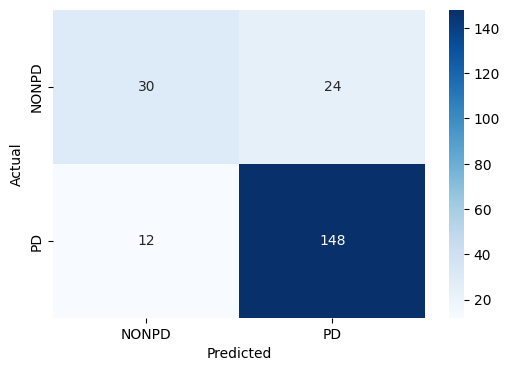

In [44]:
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=classes))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [45]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"\nModel Performance Metrics:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")


Model Performance Metrics:
Accuracy  : 0.8318
Precision : 0.8236
Recall    : 0.8318
F1 Score  : 0.8243
